### TEMPLATE MATCHING

En este trabajo práctico se busca la identificación de objetos a través de diferentes algoritmos, entre ellos __template matchin__. 

In [31]:
#Import libraries
import numpy as np
import glob
import cv2 as cv
import matplotlib.pyplot as plt
import imutils
import scipy.stats as st
from PIL import Image

#%matplotlib


### Ejercicio 1

### Detección del logo en cada imagen

In [52]:
def scale_img():
    pattern = cv.imread('./imgs/tp3/template/pattern.png', 0)
    #img_canny_list = []
    img_bitwise_list = []
    img_resized_list = []
    #Storing the height and width of template image
    #h_pattern, w_pattern = pattern_canny.shape
    #Multi-scale
    for scale in np.linspace(0.1, 1.0, 10)[::-1]:
        img_resized = imutils.resize(pattern, width=int(pattern.shape[1] * scale))
        r =  pattern.shape[1]/float(img_resized.shape[1])

        #img_canny = cv.Canny(img_resized, 50, 200)
        img_bitwise = cv.bitwise_not(img_resized)
        img_bitwise_list.append(img_bitwise)
        img_resized_list.append(img_resized)
        #img_canny_list.append(img_canny)

        #plt.figure()
        #plt.imshow(img_resized)
    return img_bitwise_list, img_resized_list


In [53]:
def read_imag():
    img_dir = './imgs/tp3/images/'
    ext = ['png', 'jpg']
    files = []
    image_gray = []
    images_canny = []
    imgs_color = []
    [files.extend(glob.glob(img_dir + '*.' + e)) for e in ext]

    images = [cv.imread(file) for file in files]

    for im in images:
        img_color = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        img_gray = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)
        image_gray.append(img_gray)
        img_canny = cv.Canny(img_gray, 50, 200)
        images_canny.append(img_canny)
        imgs_color.append(img_color)
        
    return images, image_gray, imgs_color

In [70]:
def detection_logo():
    img_dir = './imgs/tp3/images/'
    pattern = cv.imread('./imgs/tp3/template/pattern.png', 0)
    ext = ['png', 'jpg']
    files = []
    image_gray = []
    [files.extend(glob.glob(img_dir + '*.' + e)) for e in ext]

    images = [cv.imread(file) for file in files]

    #Pre-processing img pattern
    pattern_canny = cv.bitwise_not(cv.Canny(pattern, 50, 200))

    #Storing the height and width of template image
    h_pattern, w_pattern = pattern_canny.shape

    found = None
    
    for im in images:
        img_color = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        img_gray = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)
        #Array of image gray
        image_gray.append(img_gray)
        h_img, w_img = img_gray.shape

        #TODO Resize template. Armar un array con diferentes escalas de template

        #Multi-scale
        for scale in np.linspace(0.1, 1.0, 10)[::-1]:
            img_resized = imutils.resize(img_gray, width=int(img_gray.shape[1] * scale))
            r =  img_gray.shape[1]/float(img_resized.shape[1])

            if img_resized.shape[0] < h_pattern or img_resized.shape[1] < w_pattern:
                break

            img_canny = cv.Canny(img_resized, 50, 200)
            img_output = cv.matchTemplate(img_canny, pattern_canny, cv.TM_CCOEFF_NORMED)  
            (minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(img_output) 

            if found is None or maxVal > found[0]:
                found = (maxVal, maxLoc, r)
            (_, maxLoc, r) = found

            (startX, startY) = (int(maxLoc[0]*r), int((maxLoc[1]*r)))
            (endX, endY) = (int(maxLoc[0]*r +w_pattern), int((maxLoc[1]*r + h_pattern)))

            img_match = cv.rectangle(img_color, (startX, startY), (endX, endY), (0, 0, 255),2)         

        plt.figure()
        plt.imshow(img_color)
    
    #Resize of images


    return

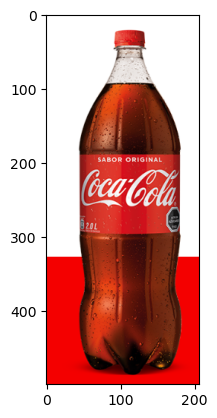

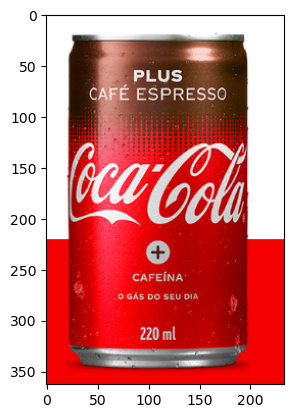

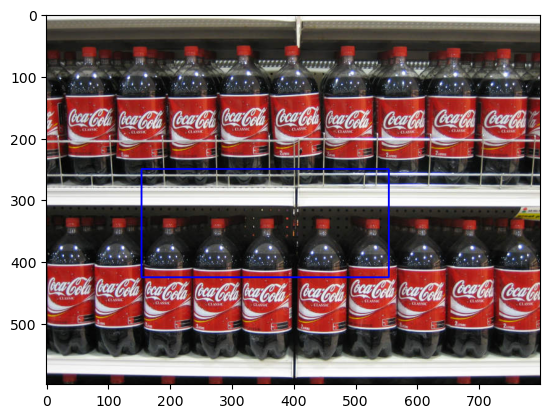

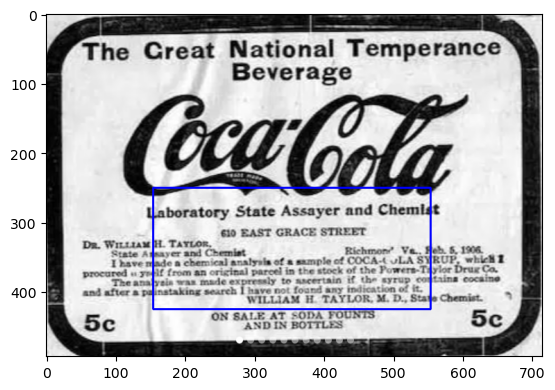

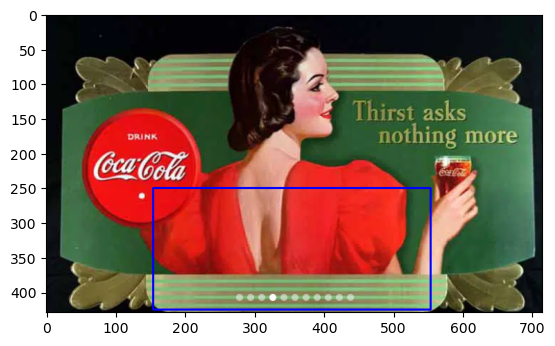

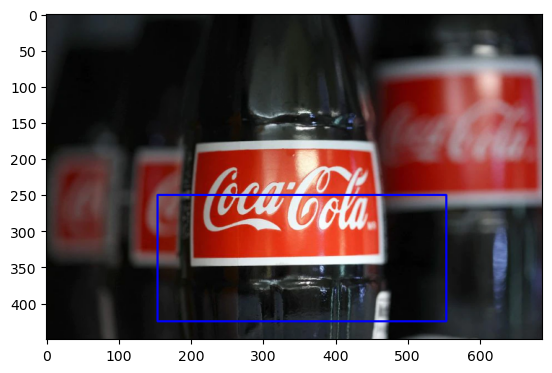

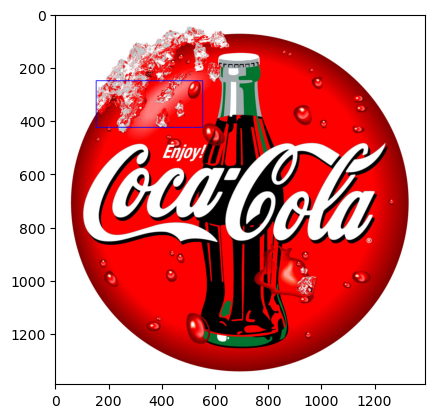

In [71]:
detection_logo()

In [60]:
def logo_detection():
    imgs, imgs_gray, images_color = read_imag()
    img_bitwise_list, image_resized_list = scale_img()

    for i, j, k in zip(range(len(image_resized_list)), range(len(imgs_gray)), range(len(images_color))):
        w_pattern,h_pattern = image_resized_list[i].shape[::-1]
        w, h = imgs_gray[j].shape[::-1]
        if w_pattern > w or h_pattern > h :
            print("Rescaling the template image")
            scale_percent_w = 0.5
            scale_percent_h = 0.9
            width = int(image_resized_list[i].shape[1]*scale_percent_w)
            heigth = int(image_resized_list[i].shape[0]*scale_percent_h)
            dim = (width,heigth)
            img_bw_rescale = cv.resize(image_resized_list[i], dim, interpolation = cv.INTER_AREA)  
            #img_bw_rescale = imutils.resize(image_resized_list[i], width=width)
            print(img_bw_rescale.shape)      
        else:
            img_bw_rescale = image_resized_list[i]

            plt.figure()
            plt.imshow(img_bw_rescale)
        
        image_canny_pattern = cv.Canny(img_bw_rescale, 50, 200)
        img_canny = cv.Canny(images_color[k], 50, 200)

        print("[INFO] performing template matching...")
        method = 'cv.TM_CCOEFF'
        img_match = cv.matchTemplate(img_canny, image_canny_pattern,eval(method))
        (minVal, maxVl, minLoc, maxLoc) = cv.minMaxLoc(img_match)
        
        top_left = maxLoc

        #Indicamos el lugar donde se produjo la coincidencia
        bottom_rigth = (top_left[0] + w, (top_left[1]+ h))

        cv.rectangle(images_color[k], top_left, bottom_rigth, (0, 0, 255), 2)

        # Results of matching
        plt.subplot(121),plt.imshow(img_match, cmap='gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        
        # Original image with bounding box
        plt.subplot(122),plt.imshow(images_color[k])
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
        
        plt.suptitle(method)
        plt.show()
    return 


Rescaling the template image
(157, 200)
[INFO] performing template matching...


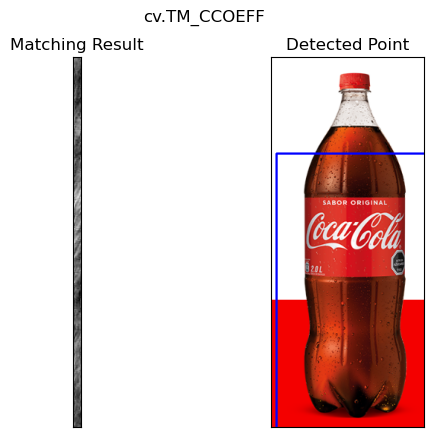

Rescaling the template image
(141, 180)
[INFO] performing template matching...


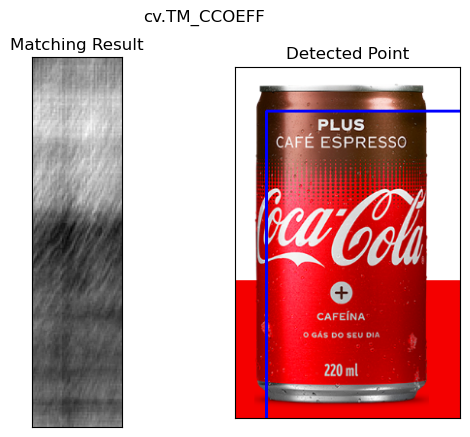

[INFO] performing template matching...


C:\Users\fSIoF\AppData\Local\Temp\ipykernel_11512\444812104.py:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121),plt.imshow(img_match, cmap='gray')


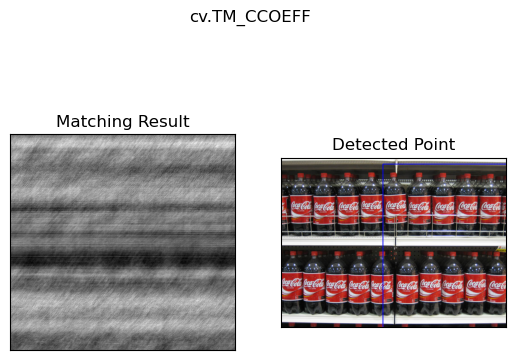

[INFO] performing template matching...


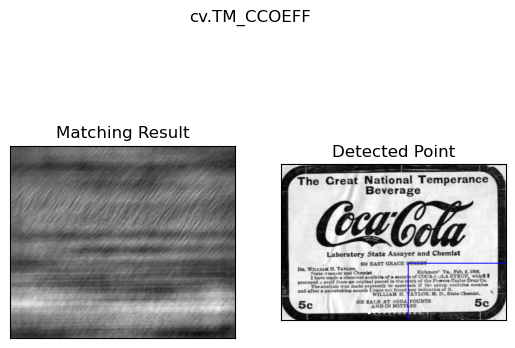

[INFO] performing template matching...


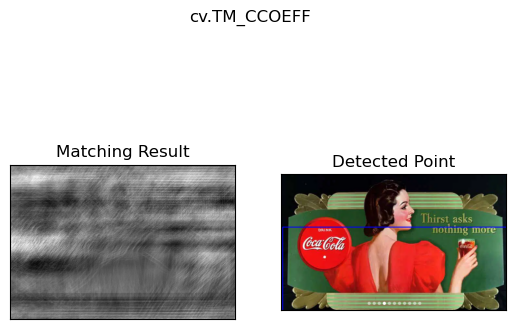

[INFO] performing template matching...


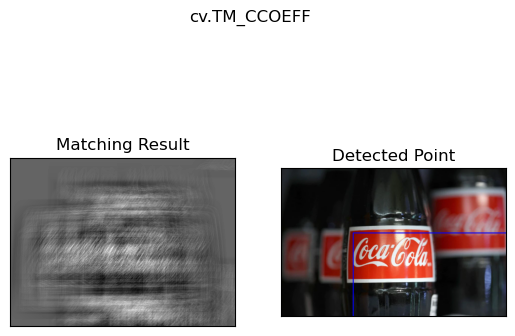

[INFO] performing template matching...


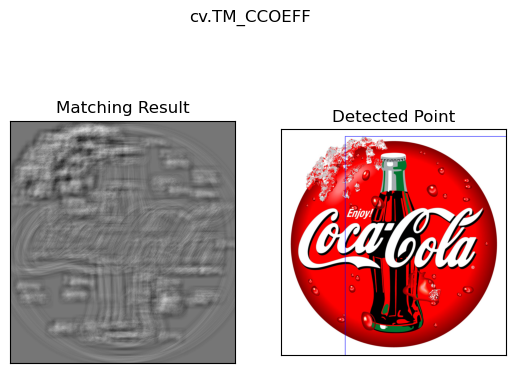

In [61]:
logo_detection()

### Ejercicio 2

In [68]:
def logo_detection_multi():
    img = cv.imread('./imgs/tp3/images/coca_multi.png')
    img_coca_cola  = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_coca_cola_gray = cv.cvtColor(img_coca_cola, cv.COLOR_BGR2GRAY)
    img_bitwise_list, img_resized_list = scale_img()


    img_template = (img_bitwise_list[8])

    w, h = img_template.shape[::-1]
    res = cv.matchTemplate(img_coca_cola_gray,img_template,cv.TM_CCORR_NORMED)

    # Fijamos un umbral de "coincidencia"
    threshold = 0.63


    loc = np.where( res >= threshold)
    for pt in zip(*loc[::-1]):
        cv.rectangle(img_coca_cola, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(img_template, cmap='gray')
    plt.title('Pattern')

    plt.subplot(122)
    plt.imshow(img_coca_cola)
    plt.title('Result')


    #cv.imwrite('res.png',img_rgb)
    return

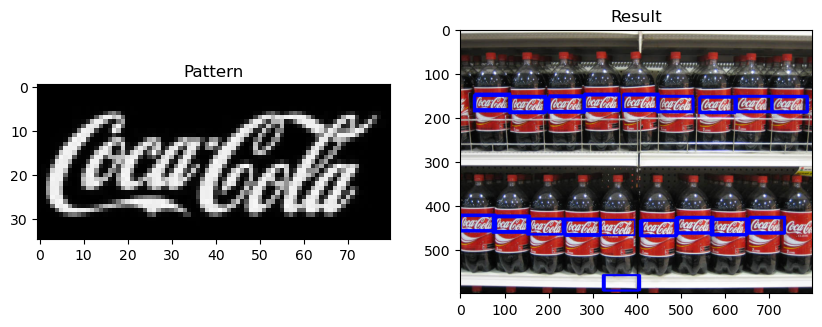

In [69]:
logo_detection_multi()

### Ejercicio 3